In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from scipy import stats 
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from itertools import combinations 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16});
plt.style.use('dark_background')
dt_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] # dark theme colors
figdir = '/Users/aqib/Desktop/UCSB/Research/BCCL/adp1/slides/'
import seaborn as sns
import pickle
from Bio import SeqIO # biopython package
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from bioservices import UniProt 
import os

### load normalized expression from results-kallisto

In [2]:
# get all sample directories
dirs = next(os.walk('.'))[1]
# remove any unwanted directories
for ii,this_dir in enumerate(dirs): 
    if this_dir[0] == '.':
        del dirs[ii]

# the order in which we want the samples in 
dirs = ['LB0R1_S7','LB0R2_S8','LB0R3_S9','LB1R1_S10','LB1R2_S11','LB1R3_S12',
       'M9L8R1_S4','M9L8R2_S5','M9L8R3_S6','M95fR1_S1','M95fR2_S2','M95fR3_S3']
nsamples = len(dirs)

# Generating a dictionary with dataframe for each sample
df_dict = {} # raw counts are available here
for this_dir in dirs:
    df_dict[this_dir] = pd.read_csv(this_dir+'/abundance.tsv',sep='\t')
target_ids = list(df_dict[this_dir].target_id)

# generate df where the first column is target_id and the next columns are TPM from each sample
temp_dict = {'target_id':target_ids}
temp_dict_cts = {'target_id':target_ids}
for sample,this_df in zip(list(df_dict.keys()),df_dict.values()): 
    temp_dict[sample] = this_df.tpm
    temp_dict_cts[sample] = this_df.est_counts
df = pd.DataFrame(temp_dict)
df.columns = ['target_id', 'LB0R1','LB0R2','LB0R3','LB1R1','LB1R2','LB1R3','M9LQR1','M9LQR2','M9LQR3',
             'M9SFR1','M9SFR2','M9SFR3']
df_cts = pd.DataFrame(temp_dict_cts)
df_cts.columns = ['target_id', 'LB0R1','LB0R2','LB0R3','LB1R1','LB1R2','LB1R3','M9LQR1','M9LQR2','M9LQR3',
             'M9SFR1','M9SFR2','M9SFR3']
df

,target_id,LB0R1,LB0R2,LB0R3,LB1R1,LB1R2,LB1R3,M9LQR1,M9LQR2,M9LQR3,M9SFR1,M9SFR2,M9SFR3
0,lcl|NC_005966.1_cds_WP_004930068.1_1,254.4710,195.2650,258.4730,275.9580,240.0250,217.3340,56.17540,55.1445,45.2804,147.6370,127.7610,157.6420
1,lcl|NC_005966.1_cds_WP_004930066.1_2,257.9470,222.5650,246.4550,334.2180,211.9420,223.8630,27.43750,51.0805,53.3345,181.7740,142.9680,218.1870
2,lcl|NC_005966.1_cds_WP_004930061.1_3,217.0360,206.5120,152.5050,141.9870,180.9460,144.0180,81.63770,64.7067,70.0990,48.5840,52.2221,57.3814
3,lcl|NC_005966.1_cds_WP_004930060.1_4,496.6680,476.1380,357.3170,399.3490,494.2160,271.7890,84.41360,91.6070,105.7230,143.1010,141.5100,151.8540
4,lcl|NC_005966.1_cds_WP_004930057.1_5,47.7092,56.7863,48.9246,133.3450,55.1851,44.6848,1739.33000,2147.7500,1420.1400,292.3550,458.4010,280.9240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,lcl|NC_005966.1_cds_WP_004930080.1_3249,84.0684,83.1013,71.1711,82.9277,76.4360,65.6913,13.62630,13.7398,13.7850,36.7306,36.9118,38.8212
3249,lcl|NC_005966.1_cds_WP_004930076.1_3250,424.3720,490.5040,355.0440,439.3470,417.1820,345.5560,34.16200,34.1776,39.3620,126.3570,64.6350,137.3820
3250,lcl|NC_005966.1_cds_WP_004930074.1_3251,630.3330,511.0390,538.2720,654.0400,683.3840,488.8550,6.47030,15.0932,20.0422,106.1690,90.2611,176.4470
3251,lcl|NC_005966.1_cds_WP_011182867.1_3252,364.1350,379.0110,528.9510,618.7390,363.8400,402.5070,4.51108,10.5030,27.7687,257.1650,213.7850,405.4190


### target_id (results-kallisto) to gene (cds_from_genomic) mapping

In [4]:
fasta_path = 'GCF_000046845.1_ASM4684v1_cds_from_genomic.fna'
genbank_path = 'GCF_000046845.1_ASM4684v1_genomic.gbff'
# fasta_records = list(SeqIO.parse(fasta_path,'fasta')) # full cds_from_genome fasta

In [5]:
def getRecords(fasta_path,genbank_path,target_ids):
    # have to use cds_from_genome.fasta because this is the where the target_ids came from (e.g. lcl|AM181176.4_cds_CAY53368.1_5775)
    fasta_records = list(SeqIO.parse(fasta_path,'fasta')) # full cds_from_genome fasta
    keep_fasta_records = [] # getting records of genes that we have used
    for tx in target_ids:
        for rec in fasta_records:
            if rec.name == tx:
                keep_fasta_records.append(rec)
    # match locus_tags in keep_records (from fasta) with tags in genbank to easily parse rest of cds' description 
    # can grab locus_tags from the fasta description, other info need to grab from the genbank
    genes, locus_tags = [],[] 
    for rec in keep_fasta_records:
        rec_elems = [x.strip().strip(']') for x in rec.description.split(' [')]
        if 'gene=' in str(rec_elems): # sequence has gene name (e.g. gene=dnaA)
            genes.append(rec_elems[1][5:])
            locus_tags.append(rec_elems[2][10:])
        elif 'gene=' not in str(rec_elems): # sequence has no gene name, but has locus tag
            genes.append('N/A')
            locus_tags.append(rec_elems[1][10:])
    gb_records = next(SeqIO.parse(genbank_path,'genbank'))
    
    locations = []
    for tag in locus_tags:
            for feature in gb_records.features:
                if feature.type == 'CDS':
                    if feature.qualifiers['locus_tag'][0] == tag: 
                        if feature.strand == 1: # 5' -> 3'
                            locations.append([feature.location.start.position,feature.location.end.position,1])
                        elif feature.strand == -1: # 3' -> 5' (complementary)
                            locations.append([feature.location.start.position,feature.location.end.position,-1])            
    
    return {'gene':genes}, {'tag':locus_tags}, {'location':locations}


In [6]:
# get gene names, locus_tags and also locations for when that might be needed
genes,tags,locs = getRecords(fasta_path,genbank_path,target_ids)
# append gene names and locus_tags
df = pd.concat([pd.DataFrame(genes),pd.DataFrame(tags),pd.DataFrame(df)],axis=1)
df_cts = pd.concat([pd.DataFrame(genes),pd.DataFrame(tags),pd.DataFrame(df_cts)],axis=1)

In [7]:
os.getcwd()

'/Users/aqib/Desktop/UCSB/Research/BCCL/adp1-adaptation/AH-YeungLab_02-305692389_2021RNAseq/FASTQ_Generation_2021-11-12_16_31_55Z-486002436/results-kallisto-v2'

In [9]:
df.head(6)

,gene,tag,target_id,LB0R1,LB0R2,LB0R3,LB1R1,LB1R2,LB1R3,M9LQR1,M9LQR2,M9LQR3,M9SFR1,M9SFR2,M9SFR3
0,dnaA,ACIAD_RS00005,lcl|NC_005966.1_cds_WP_004930068.1_1,254.4710,195.2650,258.4730,275.9580,240.0250,217.3340,56.17540,55.14450,45.28040,147.6370,127.7610,157.6420
1,dnaN,ACIAD_RS00010,lcl|NC_005966.1_cds_WP_004930066.1_2,257.9470,222.5650,246.4550,334.2180,211.9420,223.8630,27.43750,51.08050,53.33450,181.7740,142.9680,218.1870
2,recF,ACIAD_RS00015,lcl|NC_005966.1_cds_WP_004930061.1_3,217.0360,206.5120,152.5050,141.9870,180.9460,144.0180,81.63770,64.70670,70.09900,48.5840,52.2221,57.3814
3,gyrB,ACIAD_RS00020,lcl|NC_005966.1_cds_WP_004930060.1_4,496.6680,476.1380,357.3170,399.3490,494.2160,271.7890,84.41360,91.60700,105.72300,143.1010,141.5100,151.8540
4,N/A,ACIAD_RS00025,lcl|NC_005966.1_cds_WP_004930057.1_5,47.7092,56.7863,48.9246,133.3450,55.1851,44.6848,1739.33000,2147.75000,1420.14000,292.3550,458.4010,280.9240
5,N/A,ACIAD_RS00030,lcl|NC_005966.1_cds_WP_004930055.1_6,44.0670,31.2350,40.2057,62.6687,35.9092,34.1717,3.67811,9.27044,7.43292,27.2721,25.2505,28.2267


In [11]:
doWrite = False
if doWrite: 
    df.to_csv(os.getcwd()+'/TPM_matrix.csv',index=False)

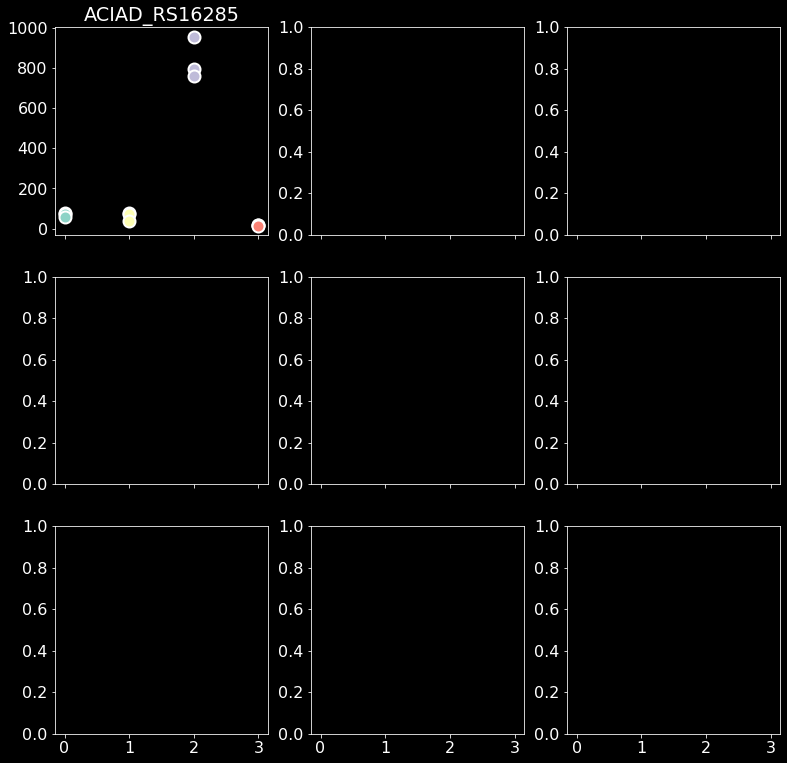

<Figure size 432x288 with 0 Axes>

In [10]:
# plot_genes = [list(df.gene).index('adhA'),list(df.gene).index('ndh'),list(df.gene).index('acoA'),
#               list(df.gene).index('acoB'),list(df.gene).index('acoD'),list(df.gene).index('aceA'), 
#               list(df.tag).index('ACIAD3600')]
plot_genes = [list(df.tag).index('ACIAD_RS16285')]
fig,axs = plt.subplots(3,3,figsize=(13,13),sharex=True)
for ii,ax in enumerate(axs.reshape(-1)):
    if ii < len(plot_genes):
        this_gene = plot_genes[ii]
        plt.figure()
        for ii in range(4):
            if df.gene[this_gene] == 'N/A':
                ax.set_title(df.tag[this_gene])
            else: 
                ax.set_title(df.gene[this_gene])
            ax.plot([ii,ii,ii],df.loc[this_gene].iloc[3+ii*3:3+ii*3+3],'o',ms=12,mec='white',mew=2)
# plt.tight_layout()
plt.show()

In [12]:
# remove low count genes
# if count is less than 5 in 6 (out of 12) or more samples, remove the gene
df_cts
high_count_mask = (df_cts.iloc[:,3:] < 5).sum(axis=1) < 7

In [13]:
df_filtered = df.loc[high_count_mask]
df_filtered.reset_index(drop=True, inplace=True)
df_cts_filtered = df_cts.loc[high_count_mask]
df_cts_filtered.reset_index(drop=True, inplace=True)
print(len(df_filtered))

3145


### dump to csv for DGEA analysis in R

In [11]:
# (df_cts_filtered.drop(df_cts_filtered.columns[[0,2]],axis=1)).to_csv(os.getcwd()+'/count_matrix_filtered.csv',index=False)

### inter-sample correlations

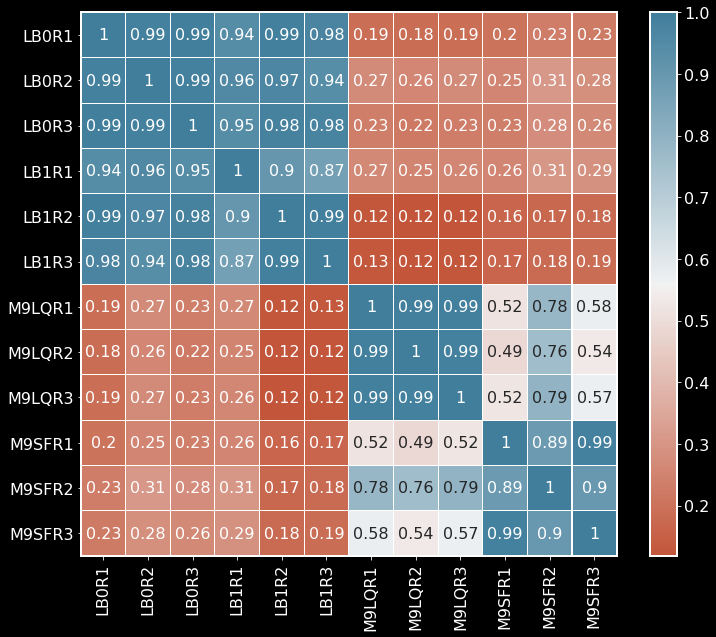

In [14]:
cmap = sns.diverging_palette(20, 230, as_cmap=True)
fig, axs = plt.subplots(figsize=(12,10))
sns.heatmap(df_filtered.iloc[:,3:].corr(),cmap=cmap,linewidths=0.05,annot=True,ax=axs)
cax = fig.axes[-1]
cax.set_frame_on(True) # set spine access on for cbar
for _,spine in axs.spines.items(): # set spines for heatmap
    spine.set_visible(True)
    spine.set_linewidth(2)
for side in cax.spines.keys():
    cax.spines[side].set_linewidth(2)
    
# plt.savefig(figdir+'intersample_corr.pdf',dpi=300,transparent=True,bbox_inches='tight')    
    
plt.show()



In [13]:
correlations = df_filtered.iloc[:,3:].T.corr()
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')
# Clusterize the data
threshold = 0.2
labels = fcluster(Z, threshold, criterion='distance')
# Keep the indices to sort labels
labels_order = np.argsort(labels)
clustered = df_filtered.iloc[labels_order,3:]
clustered_correlations = clustered.T.corr()

In [14]:
# fig, axs = plt.subplots(figsize=(14,12))
# sns.heatmap(clustered_correlations,cmap=cmap,ax=axs)
# cax = fig.axes[-1]
# cax.set_frame_on(True) # set spine access on for cbar
# for _,spine in axs.spines.items(): # set spines for heatmap
#     spine.set_visible(True)
#     spine.set_linewidth(2)
# for side in cax.spines.keys():
#     cax.spines[side].set_linewidth(2)
# axs.set_yticklabels(''); axs.set_xticklabels('')

# # plt.savefig(figdir+'gene_corr.png',transparent=True,bbox_inches='tight')    
        
# plt.show()


- The two LB (pre & post) samples are much more correlated with each other than with any of the M9 samples. 
- M9 liquid (post) correlates well within biological replicates and only with M9 Surface Replicate 2
- M9 surface (post) correlates well within biological replicates and only with M9 Liquid Replicate 2

### biological replicate variation
- statistical test for linear regression: the slope is equal to zero is the null hypothesis
- the p-value is the probability of seeing the modeled correlation when the NULL hypothesis is TRUE.

In [15]:
def t_test_simple_linear_regression(X,Y):
    '''
    Computes a linear model for X to Y and then performs t-test to determine p-value for:
    H0: slope, intercept = 0, H1: slope,intercept = slope,intercept computed from linear model
    Don't think the p-value calculation came out correct
    '''
    # fit linear model
    lm = linear_model.LinearRegression().fit(X,Y)
    # grab model parameters
    beta_hat = np.array([lm.intercept_[0],lm.coef_[0][0]])
    # concatenate column of 1's for bias
    X_ = np.column_stack((np.ones(len(X)), X))
    # standard deviation of the noise, i.e. MSE.
    # numerator (excluding sqrt) is MSE, denominator is dof
    sigma_hat = np.sqrt(np.sum(np.square(Y - X_@beta_hat)) / (X_.shape[0] - X_.shape[1])) 
    # estimate the covariance matrix for beta 
    beta_cov = np.linalg.inv(X_.T@X_)
    # the t-test statistic for each variable
    t_vals = beta_hat / (sigma_hat * np.sqrt(np.diagonal(beta_cov)))
    # compute 2-sided p-values.
    p_vals = stats.t.sf(np.abs(t_vals), X_.shape[0]-X_.shape[1])*2 
    
    return beta_hat, p_vals

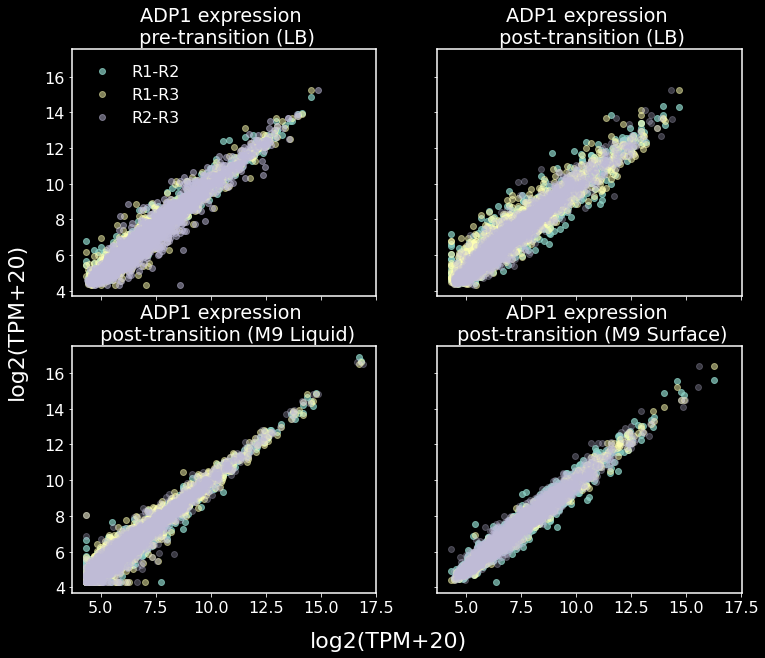

In [16]:
fig,axs = plt.subplots(2,2,figsize=(12,10),sharex=True,sharey=True)
axs[0,0].set_title('ADP1 expression \n pre-transition (LB)')
X1 = np.log2(np.array(df_filtered['LB0R1'])+20)[:,np.newaxis]
X2 = np.log2(np.array(df_filtered['LB0R2'])+20)[:,np.newaxis]
X3 = np.log2(np.array(df_filtered['LB0R3'])+20)[:,np.newaxis]
axs[0,0].scatter(X1,X2,alpha=0.7,label='R1-R2')
axs[0,0].scatter(X1,X3,alpha=0.5,label='R1-R3')
axs[0,0].scatter(X2,X3,alpha=0.5,label='R2-R3')
axs[0,0].legend(frameon=False)
axs[0,1].set_title('ADP1 expression \n post-transition (LB)')
X1 = np.log2(np.array(df_filtered['LB1R1'])+20)[:,np.newaxis]
X2 = np.log2(np.array(df_filtered['LB1R2'])+20)[:,np.newaxis]
X3 = np.log2(np.array(df_filtered['LB1R3'])+20)[:,np.newaxis]
axs[0,1].scatter(X1,X2,alpha=0.7)
axs[0,1].scatter(X1,X3,alpha=0.5)
axs[0,1].scatter(X2,X3,alpha=0.3)
axs[1,0].set_title('ADP1 expression \n post-transition (M9 Liquid)')
X1 = np.log2(np.array(df_filtered['M9LQR1'])+20)[:,np.newaxis]
X2 = np.log2(np.array(df_filtered['M9LQR2'])+20)[:,np.newaxis]
X3 = np.log2(np.array(df_filtered['M9LQR3'])+20)[:,np.newaxis]
axs[1,0].scatter(X1,X2,alpha=0.7)
axs[1,0].scatter(X1,X3,alpha=0.5)
axs[1,0].scatter(X2,X3,alpha=0.3)
axs[1,1].set_title('ADP1 expression \n post-transition (M9 Surface)')
X1 = np.log2(np.array(df_filtered['M9SFR1'])+20)[:,np.newaxis]
X2 = np.log2(np.array(df_filtered['M9SFR2'])+20)[:,np.newaxis]
X3 = np.log2(np.array(df_filtered['M9SFR3'])+20)[:,np.newaxis]
axs[1,1].scatter(X1,X2,alpha=0.7)
axs[1,1].scatter(X1,X3,alpha=0.5)
axs[1,1].scatter(X2,X3,alpha=0.3)
fig.text(0.4,0.05,'log2(TPM+20)',fontsize=22)
fig.text(0.05,0.4,'log2(TPM+20)',rotation='vertical',fontsize=22)
for ii,ax in enumerate(axs.reshape(-1)):
    for side in ax.spines.keys():
        ax.spines[side].set_linewidth(1.5)

# plt.savefig(figdir+'bio_rep_variation.pdf',dpi=300,transparent=True,bbox_inches='tight')    

plt.show()


### mean-variance relationship of RNA-seq counts
- are the data Poisson distributed or negative binomially?

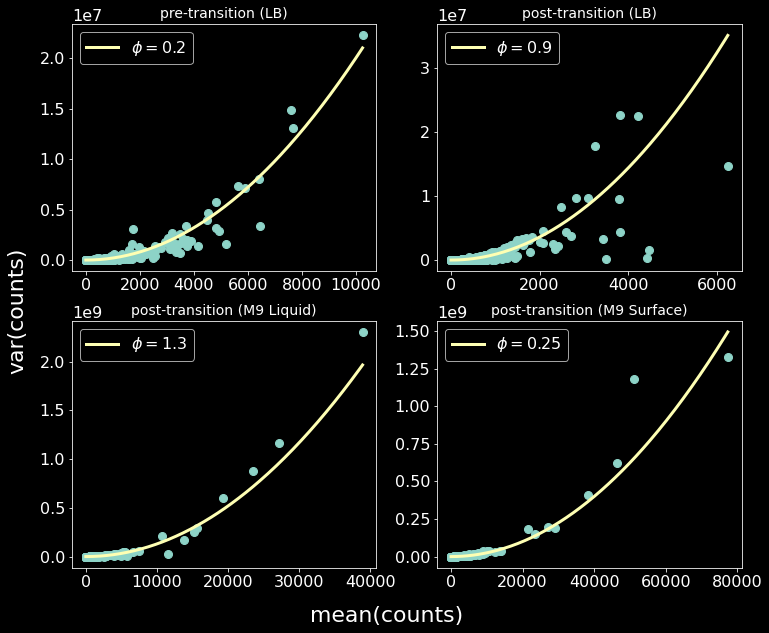

In [17]:
# raw counts
cts = 1*df_cts_filtered.iloc[:,3:]
keys = ['LB0','LB1','M9LQ','M9SF']
nreps = 3

cts_mean = np.zeros((len(df_cts_filtered),len(keys)))
cts_var = np.zeros((len(df_cts_filtered),len(keys)))
for ii in range(len(keys)):
    cts_mean[:,ii] = cts.iloc[:,+ii*nreps:3+ii*nreps+len(keys)-1].mean(axis=1)
    cts_var[:,ii] = (cts.iloc[:,+ii*nreps:3+ii*nreps+len(keys)-1].std(axis=1))**2
    
# fit negative binomial distribution 
mean_ = [np.linspace(0,np.max(cts_mean[:,0]),200),np.linspace(0,np.max(cts_mean[:,1]),200),
            np.linspace(0,np.max(cts_mean[:,2]),200),np.linspace(0,np.max(cts_mean[:,3]),200)]
dispersion = [0.2,0.9,1.3,0.25]
var_ = [mean_[0] + dispersion[0] * mean_[0]**2, mean_[1] + dispersion[1] * mean_[1]**2,
        mean_[2] + dispersion[2] * mean_[2]**2, mean_[3] + dispersion[3] * mean_[3]**2]

fig,axs = plt.subplots(2,2,figsize=(12,10))
title = ['pre-transition (LB)','post-transition (LB)'
        ,'post-transition (M9 Liquid)','post-transition (M9 Surface)']
for ii,ax in enumerate(axs.reshape(-1)):
    ax.set_title(title[ii],fontsize=14)
    ax.plot(cts_mean[:,ii],cts_var[:,ii],'o',ms=8)
    ax.plot(mean_[ii],var_[ii],lw=3,label=r'$\phi=$'+str(dispersion[ii]))
    ax.legend()
fig.text(0.4,0.05,'mean(counts)',fontsize=22)
fig.text(0.05,0.4,'var(counts)',rotation='vertical',fontsize=22)

# plt.savefig(figdir+'mean_var_relation.pdf',dpi=300,transparent=True,bbox_inches='tight')    

plt.show()


- clearly not Poisson distributed! var does not equal mean
- negative binomial fits well

### Normalization of count data

#### DESeq2 median of ratios method
- accounts for sequencing depth and RNA composition

In [15]:
# get geometric mean across all samples
geo_mean = stats.gmean(df_cts_filtered.iloc[:,3:15]+1, axis=1) # add 1 to remove zeros
# compute ratio of each sample to geo_mean. since most genes not DE, majority should have similar ratios in sample
sample_over_geo_mean = np.zeros((len(geo_mean),nsamples))
for ii in range(nsamples):
    sample_over_geo_mean[:,ii] = df_cts_filtered.iloc[:,ii+3]/geo_mean
# compute size factors for each sample (median of the ratios just calculated)
size_factors = np.median(sample_over_geo_mean,axis=0)
# calculate normalized counts (counts in sample / size factor of sample)
df_cts_filtered_norm = pd.DataFrame(data=np.zeros((len(df_cts_filtered),12)),columns=df_cts_filtered.columns[3:])
for ii,col in enumerate(df_cts_filtered_norm):
    df_cts_filtered_norm[col] = np.array(df_cts_filtered.iloc[:,ii+3])/size_factors[ii]
df_cts_filtered_norm.head(6)

,LB0R1,LB0R2,LB0R3,LB1R1,LB1R2,LB1R3,M9LQR1,M9LQR2,M9LQR3,M9SFR1,M9SFR2,M9SFR3
0,468.456232,339.792366,507.775029,528.400226,487.804609,513.557819,173.912409,154.769368,118.560593,233.638463,206.235838,245.580987
1,378.936767,308.756213,386.233134,511.355058,343.303999,421.312546,67.934535,114.643976,111.586440,229.079664,184.173399,271.431617
2,295.501148,265.412620,221.476342,201.442901,271.513886,251.013580,187.499316,134.706672,135.995974,56.700066,62.350370,66.177613
3,1708.691934,1551.272549,1312.652469,1425.595918,1881.269097,1204.510394,486.411269,478.638601,516.087287,424.823108,426.860223,441.528764
4,6.083847,6.956379,6.752328,18.594729,7.363088,7.095790,394.020302,441.379309,265.017796,31.911595,54.676478,33.347313
5,116.462217,78.125489,113.439102,172.001247,104.924010,116.193565,16.304288,37.259292,27.896610,62.113640,58.513424,63.075538


In [16]:
# these size_factors were verified to be very close to what DESeq2 computed from the count matrix
size_factors

array([1.15058775, 1.86878831, 0.74048541, 0.64534416, 1.0865006 ,
       1.12742904, 0.36800134, 0.34890625, 0.28677319, 3.50969609,
       1.04249583, 3.86837764])

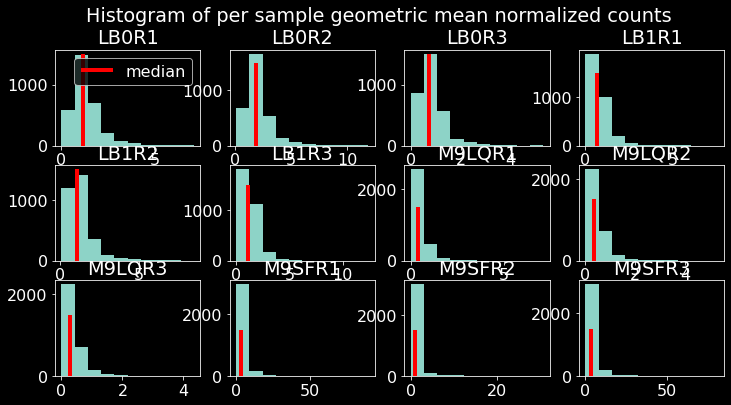

In [17]:
fig,axs = plt.subplots(3,4,figsize=(12,6))
plt.suptitle('Histogram of per sample geometric mean normalized counts')
for ii, ax in enumerate(axs.reshape(-1)):
    ax.set_title(df.columns[ii+3])
    ax.hist(sample_over_geo_mean[:,ii])
    ax.vlines(size_factors[ii],0,1500,linewidth=4,color='red',label='median')
axs[0,0].legend()

# plt.savefig(figdir+'norm_scheme.pdf',dpi=300,transparent=True,bbox_inches='tight')    

plt.show()

- Note how the ratios are most uniform in M9SF. What does this imply? 

### Let's now plot the mean variance relationships for the DESeq2 normalized counts

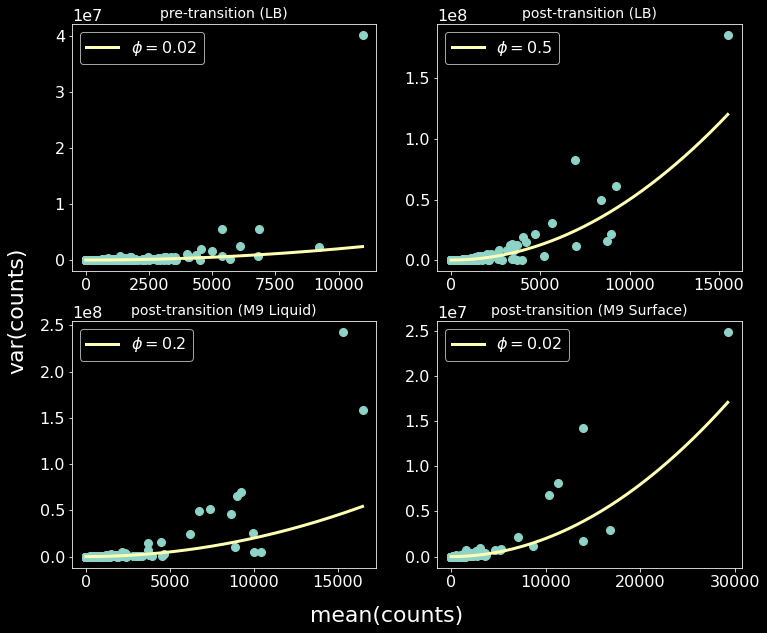

In [18]:
cts_norm = 1*df_cts_filtered_norm
keys = ['LB0','LB1','M9LQ','M9SF']
nreps = 3

cts_norm_mean = np.zeros((len(df_cts_filtered),len(keys)))
cts_norm_var = np.zeros((len(df_cts_filtered),len(keys)))
for ii in range(len(keys)):
    cts_norm_mean[:,ii] = cts_norm.iloc[:,+ii*nreps:3+ii*nreps+len(keys)-1].mean(axis=1)
    cts_norm_var[:,ii] = (cts_norm.iloc[:,+ii*nreps:3+ii*nreps+len(keys)-1].std(axis=1))**2
    
# fit negative binomial distribution 
mean_ = [np.linspace(0,np.max(cts_norm_mean[:,0]),200),np.linspace(0,np.max(cts_norm_mean[:,1]),200),
            np.linspace(0,np.max(cts_norm_mean[:,2]),200),np.linspace(0,np.max(cts_norm_mean[:,3]),200)]
dispersion = [0.02,0.5,0.2,0.02]
# dispersion = np.median(phi,axis=0)
var_ = [mean_[0] + dispersion[0] * mean_[0]**2, mean_[1] + dispersion[1] * mean_[1]**2,
        mean_[2] + dispersion[2] * mean_[2]**2, mean_[3] + dispersion[3] * mean_[3]**2]

fig,axs = plt.subplots(2,2,figsize=(12,10))
title = ['pre-transition (LB)','post-transition (LB)'
        ,'post-transition (M9 Liquid)','post-transition (M9 Surface)']
for ii,ax in enumerate(axs.reshape(-1)):
    ax.set_title(title[ii],fontsize=14)
    ax.plot(cts_norm_mean[:,ii],cts_norm_var[:,ii],'o',ms=8)
    ax.plot(mean_[ii],var_[ii],lw=3,label=r'$\phi=$'+str(dispersion[ii]))
    ax.legend()
fig.text(0.4,0.05,'mean(counts)',fontsize=22)
fig.text(0.05,0.4,'var(counts)',rotation='vertical',fontsize=22)

# plt.savefig(figdir+'norm_mean_var_relation.pdf',dpi=300,transparent=True,bbox_inches='tight')    

plt.show()


- The goal of normalization is to remove measurement noise/technical variation from the samples. 
- DESeq2 accounts for library size (reads per sample) and RNA composition (some genes are differentially expressed, stealing sequencing resources) by default

### PCA: what does it tell us?

In [19]:
# # first center the data, i.e. subtract the row means so that each gene has zero mean across all samples
# df_cts_centered = df_cts_filtered_norm.sub(df_cts_filtered_norm.mean(axis=1), axis=0)

# standardize each feature instead of only centering
scaler = StandardScaler()
scaler.fit(df_cts_filtered_norm.T)
df_cts_centered = scaler.transform(df_cts_filtered_norm.T).T

U,s,Vh = np.linalg.svd(df_cts_centered)

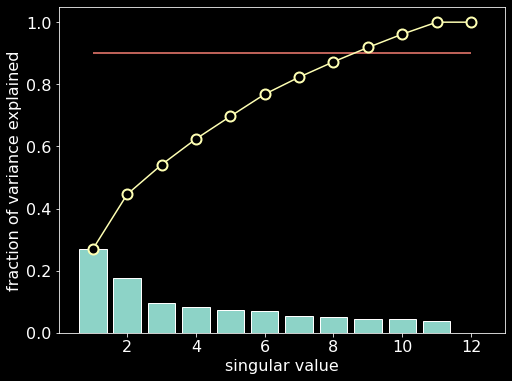

In [20]:
plt.figure(figsize=(8,6))
plt.bar(range(1,len(s)+1),s/np.sum(s),linewidth=1,edgecolor='white')
plt.plot(range(1,len(s)+1),np.cumsum(s)/(np.sum(s)),'o-',mfc='k',ms=10,mew=2,color=dt_colors[1])
plt.hlines(0.9,1,len(s),color=dt_colors[3])
plt.xlabel('singular value')
plt.ylabel('fraction of variance explained')
plt.show()

- For cross-sample standardization: with r=9 singular values, we can capture 90% of the variance in the data 

In [21]:
r = 9
Ur = U[:,:r]
Vhr = Vh[:r,:]
sr = s[:r]

In [22]:
PCs = pd.DataFrame((Ur.T @ df_cts_centered).T) # each column is a PC
samples = ['LB0','LB0','LB0','LB1','LB1','LB1','M9LQ','M9LQ','M9LQ','M9SF','M9SF','M9SF']
PCs['condition'] = samples
PCs.head(6)

,0,1,2,3,4,5,6,7,8,condition
0,-38.995625,8.977433,-11.365977,8.108961,-1.159912,6.085193,-1.984528,2.043985,-14.692212,LB0
1,-31.072941,8.355314,-23.719937,1.995227,-0.750360,2.420741,2.859546,-5.038514,16.598301,LB0
2,-37.715566,5.392968,9.063620,-10.193725,2.644334,-9.168349,-14.159896,-16.206023,-2.263307,LB0
3,-46.129427,9.233893,35.493902,9.932021,-1.430969,14.231216,4.676916,2.254749,4.859540,LB1
4,-37.173865,11.878916,-18.855697,8.739915,-0.300367,5.123969,0.409971,5.021512,-3.405209,LB1
5,-38.338397,2.893877,4.480303,-20.055707,1.784925,-20.542869,6.297025,11.995283,0.377082,LB1


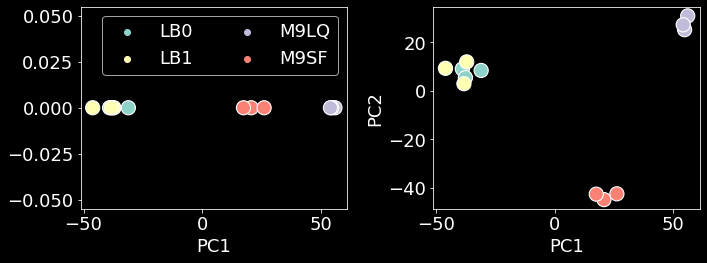

In [23]:
plt.rcParams.update({'font.size':18});
fig,axs = plt.subplots(1,2,figsize=(10,4))
sns.scatterplot(x=PCs.iloc[:,0],y=np.zeros_like(PCs.iloc[:,0]),hue=PCs['condition'],s=200,ax=axs[0])
axs[0].set_xlabel('PC1'); axs[0].set_ylabel(''); axs[0].legend(ncol=2)
sns.scatterplot(x=PCs.iloc[:,0],y=PCs.iloc[:,1],hue=PCs['condition'],s=200,ax=axs[1],legend=False)
axs[1].set_xlabel('PC1'); axs[1].set_ylabel('PC2'); 
# sns.scatterplot(x=PCs.iloc[:,0],y=PCs.iloc[:,2],hue=PCs['condition'],s=120,ax=axs[0,2],legend=False)
# axs[0,2].set_xlabel('PC1'); axs[0,2].set_ylabel('PC3'); 
# sns.scatterplot(x=PCs.iloc[:,1],y=PCs.iloc[:,2],hue=PCs['condition'],s=120,ax=axs[1,0],legend=False)
# axs[1,0].set_xlabel('PC2'); axs[1,0].set_ylabel('PC3'); 
# sns.scatterplot(x=PCs.iloc[:,3],y=PCs.iloc[:,4],hue=PCs['condition'],s=120,ax=axs[1,1],legend=False)
# axs[1,1].set_xlabel('PC4'); axs[1,1].set_ylabel('PC5'); 
# sns.scatterplot(x=PCs.iloc[:,4],y=PCs.iloc[:,5],hue=PCs['condition'],s=120,ax=axs[1,2],legend=False)
# axs[1,2].set_xlabel('PC5'); axs[1,2].set_ylabel('PC6'); 
# plt.subplots_adjust(wspace=0.35, hspace=0.25)
plt.tight_layout()

# plt.savefig(figdir+'pca_projections.pdf',dpi=300,transparent=True,bbox_inches='tight')    

plt.show()

In [24]:
# Loadings
# The columns of Ur, give the loadings for the PCs. In other words, tells us which genes are important for each PC
# get the 10 max and 10 min elements of each column of Ur
topLoadings = [] # each sublist will contain top 10 genes for corresponding PC
bottomLoadings = [] # each sublist will contain bottom 10 genes for corresponding PC
for ii in range(r):
    topLoadings.append(list(np.argsort(np.abs(Ur[:,ii]))[-10:]))
    bottomLoadings.append(list(np.argsort(np.abs(Ur[:,ii]))[:10]))

<ipython-input-26-fb52ebfde39a>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_filtered.tag[topLoadings[ii]],rotation=90)


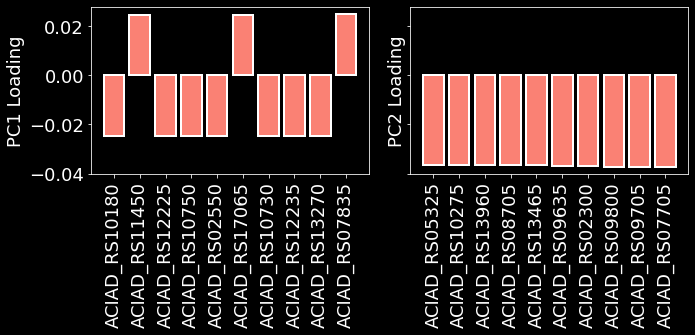

In [26]:
fig,axs = plt.subplots(1,2,figsize=(10,5),sharey=True)
for ii, ax in enumerate(axs.reshape(-1)):
    ax.set_ylabel('PC'+str(ii+1)+' Loading')
    ax.bar(df_filtered.tag[topLoadings[ii]],Ur[topLoadings[ii],ii],color=dt_colors[3],edgecolor='white',linewidth=2)
    ax.set_xticklabels(df_filtered.tag[topLoadings[ii]],rotation=90)
plt.tight_layout()

# plt.savefig(figdir+'pca_loadings.pdf',dpi=300,transparent=True,bbox_inches='tight')    

plt.show()

In [27]:
# bar chart with gene expression across conditions
df_cts_filtered_norm.loc[topLoadings[2]]


,LB0R1,LB0R2,LB0R3,LB1R1,LB1R2,LB1R3,M9LQR1,M9LQR2,M9LQR3,M9SFR1,M9SFR2,M9SFR3
2220,84.304739,86.152080,108.037240,173.550807,77.312429,105.549880,78.804060,85.982982,83.689830,84.622712,88.249754,101.851483
2413,77.351771,81.871231,58.070017,43.387702,71.790112,47.896584,73.369298,60.188088,55.793220,63.253340,55.635714,52.735286
2055,125.153427,124.679719,89.130723,38.739020,117.809415,98.454090,89.673586,88.849082,122.047669,77.214663,92.086700,88.667662
2617,150.357937,124.144612,247.135187,650.815528,127.933662,197.795153,95.108349,149.037169,174.353813,160.412750,173.621798,156.396313
2043,97.341555,67.958473,126.943757,176.649929,66.267796,84.262509,92.390967,85.982982,76.715678,90.321211,111.271429,101.592977
2592,66.922319,51.370184,66.172810,123.964862,46.939689,72.731850,67.934535,65.920286,101.125212,69.236764,73.861207,74.449815
242,249.437734,185.681813,368.677082,519.102861,220.892653,348.580696,388.585539,415.584414,453.319915,278.371681,301.200247,299.350298
1812,3.476484,1.605318,12.154190,20.144290,4.601930,8.869738,13.586907,8.598298,6.974153,7.692974,7.673892,9.564733
1728,126.891670,80.801019,179.611912,233.983678,104.924010,186.264494,119.564781,137.572772,156.918432,135.909204,169.784853,144.246517
359,138.190243,102.740369,187.714705,237.082799,122.411345,148.124621,179.347172,140.438871,170.866737,172.949448,163.070197,167.770590


In [28]:
# get replicate averages and standard deviations
df_cts_mean = df_cts_filtered_norm.groupby(np.arange(len(df_cts_filtered_norm.columns)) // 3, axis=1).mean()
df_cts_mean.columns = ['LB0','LB1','M9LQ','M9SF']
df_cts_std = df_cts_filtered_norm.groupby(np.arange(len(df_cts_filtered_norm.columns)) // 3, axis=1).std()
df_cts_std.columns = ['LB0','LB1','M9LQ','M9SF']

# do the same for the non-normalized data
df_cts_nonnorm_mean = df_cts_filtered.iloc[:,3:].groupby(np.arange(len(df_cts_filtered.iloc[:,3:].columns)) // 3, axis=1).mean()
df_cts_nonnorm_mean.columns = ['LB0','LB1','M9LQ','M9SF']
df_cts_nonnorm_std = df_cts_filtered.iloc[:,3:].groupby(np.arange(len(df_cts_filtered.iloc[:,3:].columns)) // 3, axis=1).std()
df_cts_nonnorm_std.columns = ['LB0','LB1','M9LQ','M9SF']

<ipython-input-29-9bdb10f5ca40>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_cts_mean.columns, rotation = 45)


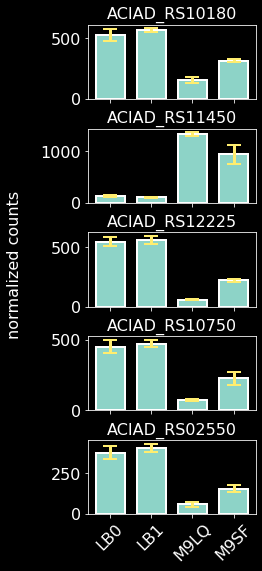

<ipython-input-29-9bdb10f5ca40>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_cts_mean.columns, rotation = 45)


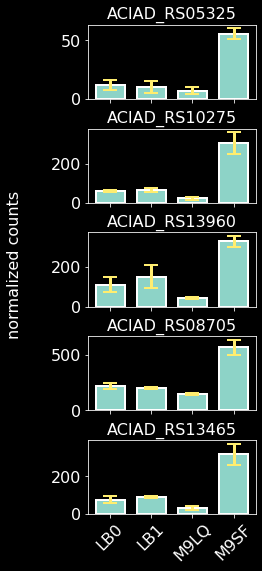

In [29]:
plt.rcParams.update({'font.size':16});

# PC1 genes
fig,axs = plt.subplots(5,1,figsize=(3,9),sharey=False,sharex=True)
for ii,ax in enumerate(axs.reshape(-1)):
    ax.set_title(df_filtered.loc[topLoadings[0][ii]].tag,fontsize=16)
    ax.bar(df_cts_mean.columns,df_cts_mean.loc[topLoadings[0][ii]],yerr=df_cts_std.loc[topLoadings[0][ii]],
            ecolor=dt_colors[9],edgecolor='white',linewidth=2,error_kw=dict(lw=3,capsize=7,capthick=2),width=0.7)
    ax.set_xticklabels(df_cts_mean.columns, rotation = 45)
fig.text(-0.25,0.4,'normalized counts',rotation='vertical')
plt.subplots_adjust(hspace=0.4)
# plt.tight_layout()

# plt.savefig(figdir+'pc1_genes_stand.pdf',dpi=300,transparent=True,bbox_inches='tight')    

plt.show()

# PC2 genes
fig,axs = plt.subplots(5,1,figsize=(3,9),sharey=False,sharex=True)
for ii,ax in enumerate(axs.reshape(-1)):
    ax.set_title(df_filtered.loc[topLoadings[1][ii]].tag,fontsize=16)
    ax.bar(df_cts_mean.columns,df_cts_mean.loc[topLoadings[1][ii]],yerr=df_cts_std.loc[topLoadings[1][ii]],
            ecolor=dt_colors[9],edgecolor='white',linewidth=2,error_kw=dict(lw=3,capsize=7,capthick=2),width=0.7)
    ax.set_xticklabels(df_cts_mean.columns, rotation = 45)
fig.text(-0.25,0.4,'normalized counts',rotation='vertical')
plt.subplots_adjust(hspace=0.4)
# plt.tight_layout()

# plt.savefig(figdir+'pc2_genes_stand.pdf',dpi=300,transparent=True,bbox_inches='tight')    

plt.show()

In [33]:
pca_targets = list(set(topLoadings[0] + topLoadings[1]))
pca_tags = list(df_filtered.loc[pca_targets].tag)

In [34]:
# get gene ontologies
def query_uniprot(species_id='ADP1',all_locus_tags='ACIAD0898',search_columns='genes,protein names,comment(FUNCTION),go,go(biological process),go(molecular function)'):
    '''
    species_id: identifier for the species given by uniprot
    all_locus_tags: list of locus tags for query
    search_columns: for the valid column names refer to the website: https://www.uniprot.org/help/uniprotkb_column_names
    '''
    query_search = '\"' + species_id + '\" AND ('
    for locus_tag in all_locus_tags[0:-1]:
        query_search = query_search + '\"' + locus_tag + '\" OR '
    query_search = query_search + '\"' + all_locus_tags[-1] + '\")'
    up = UniProt()
    search_result = up.search(query_search, frmt='tab',columns=search_columns)
    str_up_ALL = search_result.split('\n')
    ls_up = []
    for each_line in str_up_ALL[1:]:
        ls_up.append(each_line.split('\t'))
    df_up = pd.DataFrame(ls_up[0:-1])
    df_up.columns = ['gene','protein','go','go_bp','go_mf'] # str_up_ALL[0].split('\t')
    return df_up

In [35]:
search_names = 'genes,protein names,go,go(biological process),go(molecular function)'
df_pca = query_uniprot(all_locus_tags=pca_tags,search_columns=search_names)

In [36]:
pd.set_option('display.max_colwidth', None)
df_pca[['gene','protein']]

,gene,protein
0,aroA ACIAD2222,3-phosphoshikimate 1-carboxyvinyltransferase (EC 2.5.1.19) (5-enolpyruvylshikimate-3-phosphate synthase) (EPSP synthase) (EPSPS)
1,fumC ACIAD1890,Fumarate hydratase class II (Fumarase C) (EC 4.2.1.2) (Aerobic fumarase) (Iron-independent fumarase)
2,ispG ACIAD0561,4-hydroxy-3-methylbut-2-en-1-yl diphosphate synthase (flavodoxin) (EC 1.17.7.3) (1-hydroxy-2-methyl-2-(E)-butenyl 4-diphosphate synthase)
3,rplU ACIAD2939,50S ribosomal protein L21
4,rpsA ACIAD2347,30S ribosomal protein S1
5,fpr ACIAD2244,Ferredoxin--NADP reductase (EC 1.18.1.2)
6,ACIAD0507,Putative TonB
7,ACIAD1157,"Putative RND transporter, membrane fusion protein"
8,acdB ACIAD1700,Acyl-CoA dehydrogenase (EC 1.3.99.-)
9,cysI ACIAD2982,Sulfite reductase (EC 1.8.7.1)


### Negative binomial fitting

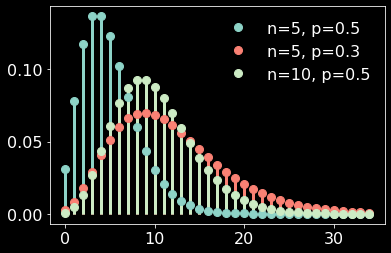

In [31]:
# First, let's get a bit of intuition behind the negative binomial
# It describes a sequence of i.i.d. Bernoulli trials, repeated until n successes with prob(success) in each trial being p
# the pmf is usually given as a counting combination of Bernoulli trials but for read count data, we prefer to think of the mean and dispersion parameterization.
# these are one-to-one
# now let's plot a few pmf's of a nb distribution given an n and a p

x = np.arange(0,35,dtype=int)
n1,p1 = 5, 0.5 # fair Bernoulli trials
n2,p2 = 5, 0.3 # biased trials
n3,p3 = 10,0.5 # fair with larger n

plt.figure()
plt.plot(x,stats.nbinom.pmf(x,n1,p1),'o',ms=8,label='n='+str(n1)+', '+'p='+str(p1))
plt.vlines(x,0,stats.nbinom.pmf(x,n1,p1),colors=dt_colors[0],lw=3)
plt.plot(x,stats.nbinom.pmf(x,n2,p2),'o',c=dt_colors[3],ms=8,label='n='+str(n2)+', '+'p='+str(p2))
plt.vlines(x,0,stats.nbinom.pmf(x,n2,p2),colors=dt_colors[3],lw=3)
plt.plot(x,stats.nbinom.pmf(x,n3,p3),'o',c=dt_colors[8],ms=8,label='n='+str(n3)+', '+'p='+str(p3))
plt.vlines(x,0,stats.nbinom.pmf(x,n3,p3),colors=dt_colors[8],lw=3)
plt.legend(frameon=False)
plt.show()

In [32]:
def pmf_nb(x,mu,phi):
    ''' 
    Return the log probability that we observe x given mean and dispersion parameters mu and phi.
    Note that we first convert to the usual # of successes and prob(success) parameterization to use scipy or even numpy nbinom functions
    '''
    p = 1/(1 + mu*phi)
    n = 1/phi
    return stats.nbinom.pmf(x,n,p)


- Method of moments to identify the parameters of the NB which maximize the likelihood of the data

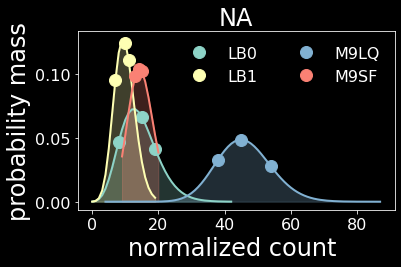

In [37]:
# the mean is given by the sample mean within a group can use the mean-variance relationship of the NB to estimate the dispersion phi
phi = (df_cts_std**2 - df_cts_mean)/(df_cts_mean**2)
phi[phi <= 0.0] = 10e-8

my_colors = [dt_colors[0],dt_colors[1],dt_colors[4],dt_colors[3]]
for this_gene in [list(df_cts_filtered['tag']).index('ACIAD_RS16280')]: 
    fig,ax = plt.subplots(1,1,figsize=(6,4),sharex=True,sharey=True)
    this_name = df_filtered.loc[this_gene].gene
    if this_name == 'N/A':
        this_name = 'NA'
    ax.set_title(this_name,fontsize=24)
    for ii,this_cond in enumerate(['LB0','LB1','M9LQ','M9SF']):    
        this_x = np.array(df_cts_filtered_norm.loc[this_gene][[this_cond+'R1',this_cond+'R2',this_cond+'R3']],dtype=int)
        this_mean = df_cts_mean.loc[this_gene][this_cond]
        this_std = df_cts_std.loc[this_gene][this_cond]
        this_phi = phi.loc[this_gene][this_cond]
        x = np.linspace( (this_mean - 5*this_std) if (this_mean - 5*this_std) >= 0.0 else 0.0 ,this_mean + 5*this_std,250,dtype=int)
        ax.plot([],[],'o',c=dt_colors[0],ms=8)
        ax.plot(x,pmf_nb(x,this_mean,this_phi),c=my_colors[ii],lw=2)     # nb pmf
        ax.fill_between(x,np.zeros_like(x),pmf_nb(x,this_mean,this_phi),interpolate=True,alpha=0.25,color=my_colors[ii])
        ax.plot(this_x,pmf_nb(this_x,this_mean,this_phi),'o',ms=12,c=my_colors[ii],label=this_cond) # likelihood  of the observed data
        ax.legend(frameon=False,loc='upper right',ncol=2)
        ax.set_xlabel(r'normalized count ',fontsize=24)
        ax.set_ylabel(r'probability mass',fontsize=24)
    plt.tight_layout()
    plt.savefig('/Users/aqib/Desktop/coaD_nbbinom_all_conds.pdf',transparent=True,bbox_inches='tight')  
    plt.show()

- Fitting the parameters of the GLM (not NB GLM, haven't gotten there yet)

In [167]:
log2FC = []
beta_list = []
Y_list = []
# compare the following two conditions 
groups = ['LB0','M9SF'] # control, treatment
conds = [[groups[0]+'R1',groups[0]+'R2',groups[0]+'R3'],[groups[1]+'R1',groups[1]+'R2',groups[1]+'R3']]
# the design matrix is simple 
X = np.array([[1,1,1,1,1,1],[0,0,0,1,1,1]]).T
# get log2FC estimate for all genes
for this_gene in range(len(df_cts_filtered_norm)):
    # arrange data vector with the counts of control first and then counts of treatment (based on design matrix setup)
    Y = np.array(pd.concat([df_cts_filtered_norm.loc[this_gene][conds[0]],df_cts_filtered_norm.loc[this_gene][conds[1]]]))
    Y = np.log2(Y + 1)
    Y_list.append(Y)
    # OLS
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y
    # # Ridge regression 
    # lam = 0.1
    # beta = np.linalg.inv(X.T @ X + lam*np.eye(2)) @ X.T @ Y
    beta_list.append(beta)
    log2FC.append(beta[1]) # beta[0] is simply the mean of the normalized counts of the control condition


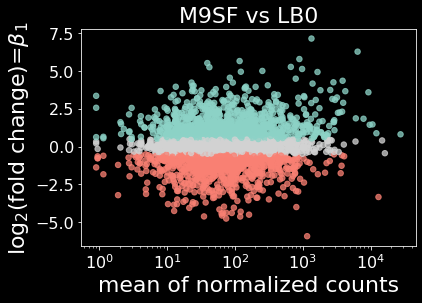

In [168]:
fig,ax = plt.subplots(1,1,figsize=(6,4),sharex=True,sharey=True)

ax.set_title(groups[1] + ' vs ' + groups[0],fontsize=22)
these_colors = ['lightgray'] * len(log2FC)
for ii,elem in enumerate(log2FC):
    if log2FC[ii] >= 0.5 :
        these_colors[ii] = dt_colors[0]
    elif log2FC[ii] <= -0.5:
        these_colors[ii] = dt_colors[3]
ax.scatter(df_cts_mean['M9LQ'],log2FC,s=30,c=these_colors,alpha=0.75)
# ax.hlines(0,np.min(res[comp].baseMean)-100,np.max(res[comp].baseMean)+100,color=dt_colors[1],linewidth=4)

ax.set_xscale('log')
ax.set_xlabel('mean of normalized counts',fontsize=22) 
ax.set_ylabel(r'$\log_2$(fold change)'+'='+ r'$\beta_1$',fontsize=22) 
# plt.savefig(figdir+'MA_OLS.pdf',transparent=True,bbox_inches='tight')  
# plt.tight_layout()
plt.show()


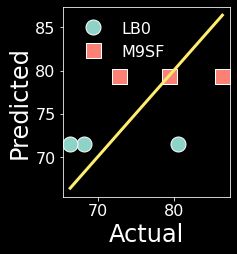

In [172]:
plt.figure(figsize=(3,3.5))
kk = 2465
plt.plot(2**Y_list[kk][:3],2**(X @ beta_list[kk])[:3],'o',ms=15,mec='white',c=dt_colors[0],label='LB0')
plt.plot(2**Y_list[kk][3:],2**(X @ beta_list[kk])[3:],'s',ms=15,mec='white',c=dt_colors[3],label='M9SF')
plt.plot(2**np.linspace(np.min(Y_list[kk]),np.max(Y_list[kk]),10),2**np.linspace(np.min(Y_list[kk]),np.max(Y_list[kk]),10),
            c=dt_colors[9],lw=3)   
plt.legend(frameon=False)
plt.xlabel('Actual',fontsize=24); plt.ylabel('Predicted',fontsize=24)
# plt.savefig('/Users/aqib/Desktop/coaD_not_affected.pdf',transparent=True,bbox_inches='tight')  
plt.show()


- The NB is typically parameterized by number of failures k, before n successes with P(success) = p
- can go from this description to the mean, variance, overdispersion relation with: 
$n= 1/\phi$, and $p = 1/(1+\mu \phi)$

In [38]:
# DGEA typically assume that dispersion is constant across genes in a condition (we will use the median)
this_cond = 'LB1' 
this_gene = 0

# need the mean and dispersion for negative binomial parameterization
disps = np.median(phi,axis=0) # vector of dispersions for each condition
disp_dict = {}
for ii in range(len(disps)):
    disp_dict[df_cts_mean.columns[ii]] = disps[ii]
mu = df_cts_mean[this_cond][this_gene]
n, p = 1/disp_dict[this_cond], 1/(1+mu*disp_dict[this_cond])

In [39]:
# generate nnb number of samples from NB distribution using sample mean vector for parameterization of p
# using constant dispersion across genes
nnb = 2
samples = np.zeros((len(df_cts_mean[this_cond]),nnb))
for ii in range(nnb):
    samples[:,ii] = np.random.negative_binomial(n,1/(1+np.array(df_cts_mean[this_cond])*disp_dict[this_cond]))  

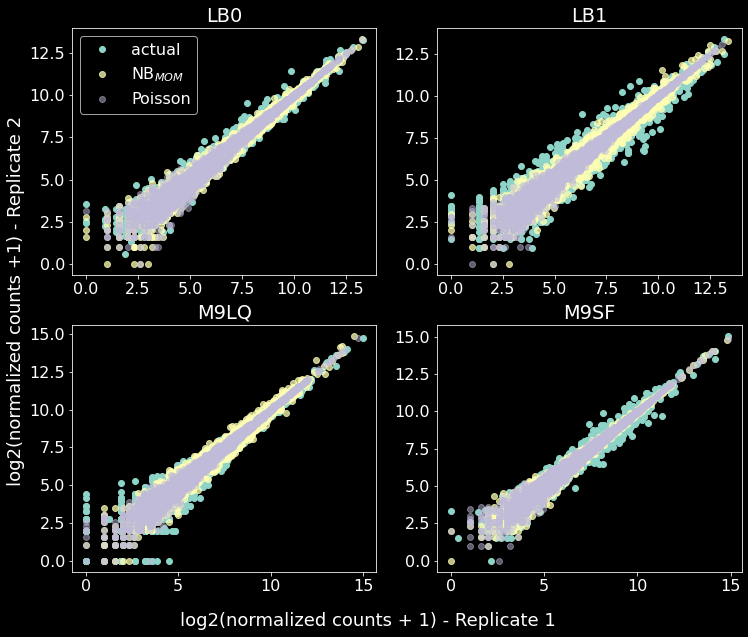

In [40]:
fig,axs = plt.subplots(2,2,figsize=(12,10));
for ii,ax in enumerate(axs.reshape(-1)):
    # get condition
    this_cond = df_cts_mean.columns[ii]
    # get dispersion
    disp = disp_dict[this_cond]
    # convert from disp to n
    n = 1/disp
    # generate two expression vectors from the negative binomial (two for plotting purposes)
    samples = np.zeros((len(df_cts_mean[this_cond]),2))
    samples_pois = np.zeros((len(df_cts_mean[this_cond]),2))
    for jj in range(2):
        samples[:,jj] = np.random.negative_binomial(n,1/(1+df_cts_mean[this_cond]*disp))  
        samples_pois[:,jj] = np.random.poisson(df_cts_mean[this_cond])  
    # plot
    ax.set_title(this_cond)
    ax.plot(np.log2(df_cts_filtered_norm[this_cond+'R1']+1),np.log2(df_cts_filtered_norm[this_cond+'R2']+1)
            ,'o',label='actual')
    ax.plot(np.log2(samples[:,0]+1),np.log2(samples[:,1]+1),'o',alpha=0.75,label=r'NB$_{MOM}$')
    ax.plot(np.log2(samples_pois[:,0]+1),np.log2(samples_pois[:,1]+1),'o',alpha=0.5,label='Poisson')
    
axs[0,0].legend()

fig.text(0.25,0.05,'log2(normalized counts + 1) - Replicate 1',fontsize=18)
fig.text(0.05,0.25,'log2(normalized counts +1) - Replicate 2',rotation='vertical',fontsize=18)

# plt.savefig(figdir+'comp_fits_norm.pdf',dpi=300,transparent=True,bbox_inches='tight')    

plt.show()

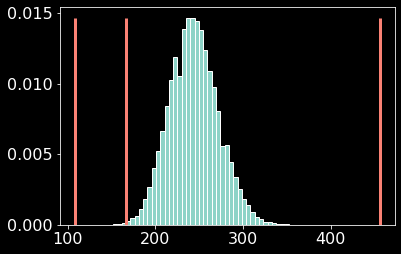

In [42]:
# DGEA typically assume that dispersion is constant across samples (we will use the median)
this_cond = 'LB0' 
this_gene = 2855
# need the mean and dispersion for negative binomial parameterization
disps = np.median(phi,axis=0) # vector of dispersions for each condition
disp_dict = {}
for ii in range(len(disps)):
    disp_dict[df_cts_mean.columns[ii]] = disps[ii]
mu = df_cts_mean[this_cond][this_gene]
n, p = 1/disp_dict[this_cond], 1/(1+mu*disp_dict[this_cond])
gene_samples = np.random.negative_binomial(n,p,100000)

plt.figure()
values, bins, _ = plt.hist(gene_samples,bins=50,density=True,cumulative=False,edgecolor='white')
for rep in ['R1','R2','R3']:
    plt.vlines(df_cts_filtered_norm[this_cond+rep][this_gene],0,max(values),color=dt_colors[3],linewidth=3)
# area = sum(np.diff(bins)*values)

plt.show()

### Maximum Likelihood Estimation for Negative Binomial
This will be a self-contained section for now

- Since NB is commonly and algorithmically implemented using the success-failure parameterization, we will employ MLE on that and then convert the params to the Gamma-Poisson interpretation
- Specifically if we have NB(r,p) for r successes before n failures with probability p of success, then \
$\phi = 1/r$ and $\lambda=(1/p - 1)/\phi$ 

In [36]:

import numpy as np
import pandas as pd

df_cts_filtered_norm


,LB0R1,LB0R2,LB0R3,LB1R1,LB1R2,LB1R3,M9LQR1,M9LQR2,M9LQR3,M9SFR1,M9SFR2,M9SFR3
0,470.671770,340.350432,507.128527,529.756090,487.641820,511.234623,173.345481,153.703767,117.662262,234.644721,206.322543,246.108290
1,380.728927,309.263306,385.741379,512.667184,343.189432,419.406642,67.713078,113.854642,110.740953,230.066288,184.250829,272.014426
2,296.898705,265.848527,221.194357,201.959800,271.423277,249.878063,186.888096,133.779204,134.965536,56.944268,62.376583,66.319708
3,1716.773098,1553.820321,1310.981191,1429.253966,1880.641283,1199.061517,484.825642,475.343130,512.176907,426.652780,427.039681,442.476799
4,5.239389,6.431819,6.743730,18.642443,6.440552,7.063691,373.776193,409.876711,249.167144,28.329058,53.739825,31.605486
...,...,...,...,...,...,...,...,...,...,...,...,...
3148,151.942278,139.892067,136.223354,153.800155,150.892941,149.220469,40.627847,37.002759,34.606548,56.371964,57.578384,58.547867
3149,1009.455596,1099.841082,896.916144,1084.368770,1091.213582,1047.192164,135.426157,119.547374,131.504881,258.681498,132.430283,275.900346
3150,151.069047,114.164791,136.223354,167.781987,173.894913,143.922700,2.708523,5.692732,6.921310,21.175255,19.192795,36.786713
3151,126.618565,122.740550,194.219436,228.369927,136.171678,173.060425,2.708523,5.692732,13.842619,74.685698,65.255502,120.722593
